In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, normalized_mutual_info_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import scipy.cluster.hierarchy as shc
from sklearn.neighbors import NearestNeighbors
import time
import gdown
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


In [ ]:
dados_sem_outliers = pd.read_csv(SGP_dados_regressão_v3_qc_leq_1.csv,header = )


In [ ]:
# Estatística descritiva básica
dados_sem_outliers.describe()

,Mass_BC_PSAP_STP,Mass_ammonium_STP,Mass_chloride_STP,Mass_nitrate_STP,Mass_organics_STP,Mass_sulfate_STP,diam_geom_medio,conc D<50,conc D>100,area,vol,Scattering_Eff
count,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000
mean,0.037165,0.107764,0.002010,0.179465,0.522490,0.151105,55.789980,0.497718,0.241814,77.304993,2.318137,2.510138
std,0.035954,0.061179,0.005447,0.136673,0.173688,0.081497,18.752975,0.188518,0.141558,40.567595,1.397366,0.795605
min,0.000985,-0.220109,-0.030028,0.008770,0.092134,0.004975,18.988360,0.084350,0.007710,16.462445,0.450857,0.117509
25%,0.016108,0.063487,-0.000505,0.056134,0.382181,0.092231,41.928135,0.351302,0.126181,45.979204,1.268507,1.947145
50%,0.026869,0.107682,0.001900,0.141237,0.534981,0.135417,53.115010,0.489944,0.218563,69.213070,1.976909,2.421218
75%,0.044801,0.152475,0.004526,0.282391,0.665079,0.194024,68.007119,0.629595,0.338304,101.514092,3.074092,3.015973
max,0.321580,0.532745,0.034410,0.623152,0.941757,0.629101,130.684068,0.962079,0.742413,284.045444,9.693169,4.788225


In [ ]:
# Exemplo: alvo contínuo com valores negativos
y = dados_sem_outliers['Scattering_Eff']  # seu vetor alvo

# Calculamos o shift para deixar os valores do alvo positivos
min_y = y.min()
eps = 1e-6  # pequeno deslocamento de segurança
shift = -min_y + eps  # garante todos positivos

# Aplicando a transformação log(alvo+1) após fazer shift
y_log = np.log1p(y + shift)

In [ ]:
from sklearn.model_selection import train_test_split

# Separação de variáveis preditoras e alvo
X = dados_sem_outliers.drop(['Scattering_Eff'], axis=1) # Características
y = dados_sem_outliers['Scattering_Eff'] # Alvo

y_bins = pd.qcut(y_log, q=25, labels=False, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y_bins)

In [ ]:
# Escalonando os preditores X
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Regressão Multilinear sem regularização

Agora que já exploramos um pouco do comportamento geral dos dados e os tratamos, retirando outliers com base no Quality Check, dividindo entre treino e teste e então os escalonando, vamos como primeira abordagem implementar uma Regressão Multilinear para tentar predizer o valor do alvo. Inicialmente, utilizamos todos os preditores selecionados em nosso tratamento anterior; em seguida, tendo observado que tais preditores estão correlacionados com a matriz de correlação apresentada e sabendo que tal correlação pode prejudicar o desempenho da regressão multilinear, utilizamos apenas os preditores que são "representantes de cada classe de correlação" isto é, preditores selecionados dentre cada conjunto de preditores correlacionados, a partir de sua correlação com o alvo, o que foi feito anteriormente. Fazemos isso numa tentativa de otimizar o desempenho dessa regressão e também de melhorar a interpretabilidade dos resultados (pois serão menos preditores).

In [ ]:
# Modelo com todos os preditores sem regularização e sem otimização

from sklearn import linear_model
regr = linear_model.LinearRegression() # Criando o regressor
regr.fit(X_train_s, y_train) # Teinando o regressor

y_pred_train = regr.predict(X_train_s) # predição para o conjunto de treino
y_pred_test = regr.predict(X_test_s) # predição para o conjunto de teste

print('Intercepto:', regr.intercept_)
print('Coeficientes:', regr.coef_)
print('R^2 = ', regr.score(X_train_s, y_train)) # Determinando R^2

Intercepto: 1.4950098647059833
Coeficientes: [ 0.675473    0.12436566  0.34136821  1.174401   -0.09900149  1.28519591
  0.0081039   0.51175196 -0.2718546  -4.8769558   7.23827182]
R^2 =  0.22983681398634082


In [ ]:
# Vamos ver o desempenho
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão linear múltipla sem regularização e com todos os preditores')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão linear múltipla sem regularização e com todos os preditores
Desempenho no conjunto de treino
R^2 =  0.22983681398634082
MSE =  0.487192204546176
MAE =  0.560586061517198
Desempenho no conjunto de teste
R^2 =  0.19358376521351228
MSE =  0.5113008417536572
MAE =  0.57090258106672


Calulamos também o R^2 ajustado para levar em consideração a quantidade de parâmetros.

In [ ]:
# --- R² normal ---
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# --- R² ajustado ---
def r2_adjusted(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# treino
n_train, p = X_train_s.shape
r2_adj_train = r2_adjusted(r2_train, n_train, p)

# teste
n_test, p = X_test_s.shape
r2_adj_test = r2_adjusted(r2_test, n_test, p)

# --- Resultados ---
print(f"R² Ajustado Treino: {r2_adj_train:.4f}")
print(f"R² Ajustado Teste : {r2_adj_test:.4f}")

R² Ajustado Treino: 0.2280
R² Ajustado Teste : 0.1857


In [ ]:
# Modelo com todos os preditores - statsmodels
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train_s) # adicionar uma coluna constante para o statsmodels ajustar um itercepto
mod = sm.OLS(y_train.reset_index(drop=True), X_train_sm) # ajustar o modelo
regsm = mod.fit()
print(regsm.summary())

                            OLS Regression Results                            
Dep. Variable:         Scattering_Eff   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     122.5
Date:                Sun, 23 Nov 2025   Prob (F-statistic):          2.92e-246
Time:                        04:05:45   Log-Likelihood:                -4795.9
No. Observations:                4527   AIC:                             9616.
Df Residuals:                    4515   BIC:                             9693.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.4950      0.23

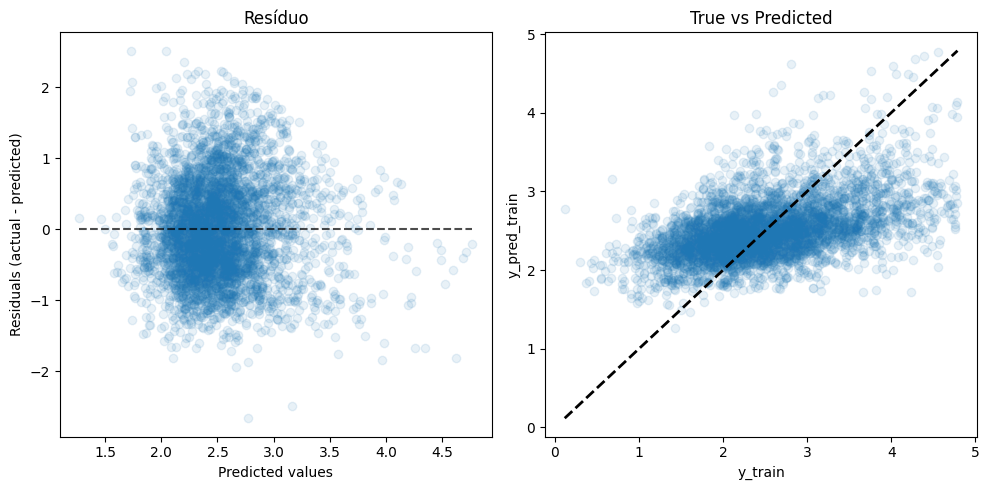

In [ ]:
# Gráfico dos resíduos para o conjunto de treinamento - todos os preditores
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plotresid = PredictionErrorDisplay(y_true=y_train, y_pred=y_pred_train)
plotresid.plot(ax=ax[0], scatter_kwargs={'alpha': 0.1}) # Plot on the first axes
ax[0].set_title('Resíduo')

ax[1].scatter(y_train, y_pred_train, alpha=.1)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('y_pred_train')
ax[1].set_title('True vs Predicted')
# Add a 1:1 dashed line
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

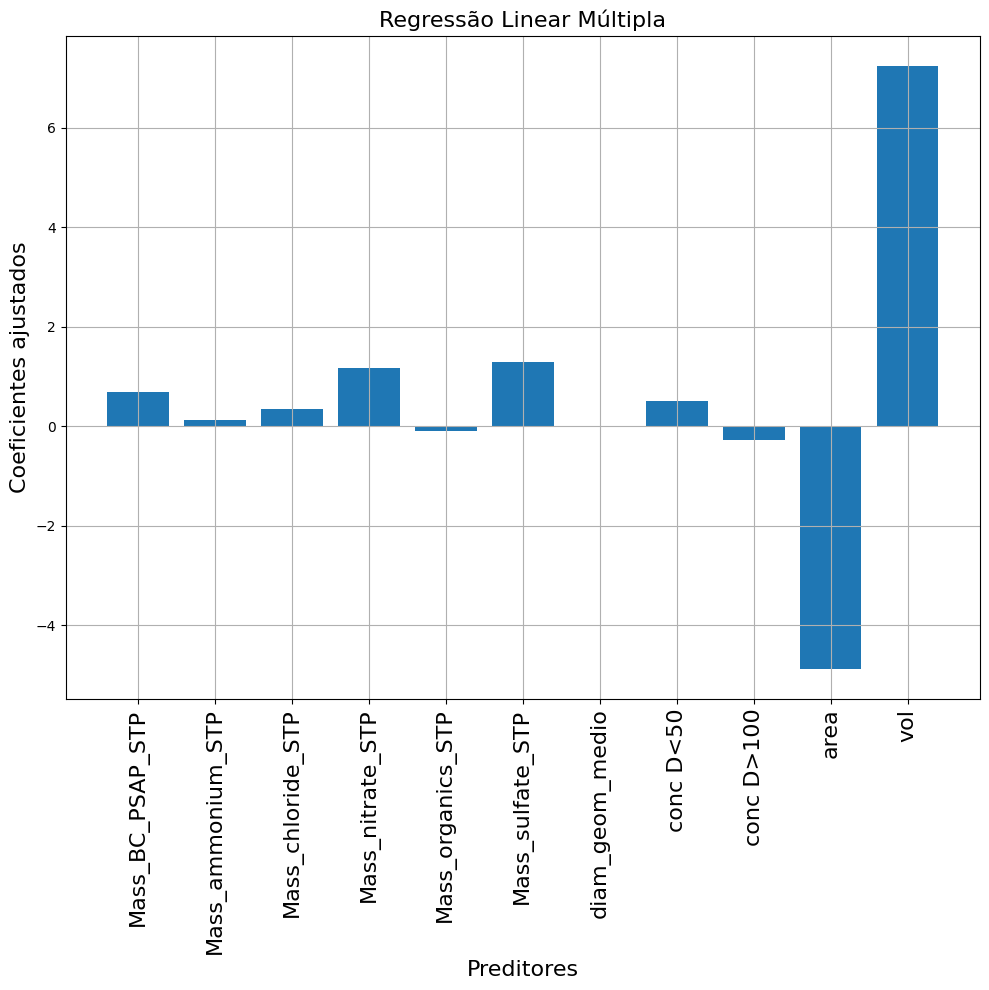

In [ ]:
# Gráfico dos coeficientes ajustados
nomes = X_train_s.columns
coef = regr.coef_
fig, ax = plt.subplots(figsize=(10, 10)) # Create figure and axes with desired size
ax.bar(np.arange(len(coef)), coef)
ax.set_xticks(np.arange(len(coef))) # Set the tick locations on the axes
ax.set_xticklabels(nomes, rotation=90, fontsize=16) # Set the tick labels and rotate on the axes
ax.set_xlabel("Preditores", fontsize=16)
ax.set_ylabel("Coeficientes ajustados", fontsize=16)
ax.set_title("Regressão Linear Múltipla", fontsize=16)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.grid()
plt.show()

As métricas indicam que o desempenho do modelo não foi muito satsfatório. O R^2 (e R^2 ajustado) não estão muito altos nem no treino, nem no teste; isso indica que o modelo não está descrevendo muito bem os dados. O MSE e MAE relativamente altos apontam que ainda pode haver outliers na previsão. Os gráficos de resíduos e de verdadeiro vs predito também revelam um problema do modelo, especialmente na predição para valores mais altos do alvo. A saída do statsmodels indica que há forte multicolinearidade, o que faz sentido considerando que vimos que há preditores que são correlacionados, e o próximo passo é buscar otimizar a regressão utilizando o conjunto de preditores selecionados a partir da correlação com o alvo. De fato, os preditores mais importantes foram área e volume, que têm uma correlação forte, como pode ser visto abaixo.

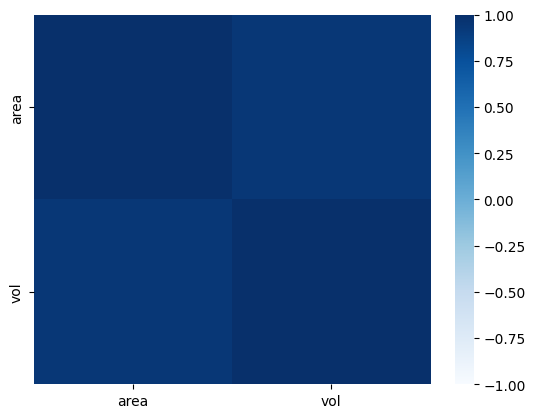

In [ ]:
# Matriz de correlação entre os dois maiores preditores acima

matriz_corr = dados_sem_outliers[["area","vol"]].corr().round(2) #Criando a matriz
sns.heatmap(matriz_corr, cmap = 'Blues', vmin=-1, vmax=1); #Fazendo o heatmap

# Regressão Multilinear sem reguarização - Preditores selecionados

Vamos proceder como acima, agora, contudo, com os preditores selecionados a partir da correlação, em uma tentativa de melhorar o desempenho da regressão.

In [ ]:
# Modelo preditores não muito correlacionados e sem regularização

from sklearn import linear_model
regr = linear_model.LinearRegression() # Criando o regressor
regr.fit(X_train_s_reduced, y_train) # Teinando o regressor

y_pred_train = regr.predict(X_train_s_reduced) # predição para o conjunto de treino
y_pred_test = regr.predict(X_test_s_reduced) # predição para o conjunto de teste

print('Intercepto:', regr.intercept_)
print('Coeficientes:', regr.coef_)
print('R^2 = ', regr.score(X_train_s_reduced, y_train)) # Determinando R^2

Intercepto: 1.1172852475316084
Coeficientes: [ 0.82797713  0.71680481  0.42295336  1.81067364 -0.55189986  2.06465968
 -0.02580046  2.34202796]
R^2 =  0.15018120767798782


In [ ]:
# Vamos ver o desempenho
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão linear múltipla sem regularização e com preditores selecionados')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão linear múltipla sem regularização e com preditores selecionados
Desempenho no conjunto de treino
R^2 =  0.15018120767798782
MSE =  0.5375809937619987
MAE =  0.5934301020562049
Desempenho no conjunto de teste
R^2 =  0.13891027468522832
MSE =  0.5459660686214219
MAE =  0.5965555052313025


In [ ]:
# --- R² normal ---
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# --- R² ajustado ---
def r2_adjusted(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# treino
n_train, p = X_train_s.shape
r2_adj_train = r2_adjusted(r2_train, n_train, p)

# teste
n_test, p = X_test_s.shape
r2_adj_test = r2_adjusted(r2_test, n_test, p)

# --- Resultados ---
print(f"R² Ajustado Treino: {r2_adj_train:.4f}")
print(f"R² Ajustado Teste : {r2_adj_test:.4f}")

R² Ajustado Treino: 0.1481
R² Ajustado Teste : 0.1305


In [ ]:
# Modelo preditores selecionados - statsmodels
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train_s_reduced.reset_index(drop=True)) # adicionar uma coluna constante para o statsmodels ajustar um itercepto
mod = sm.OLS(y_train.reset_index(drop=True), X_train_sm) # ajustar o modelo
regsm = mod.fit()
print(regsm.summary())

                            OLS Regression Results                            
Dep. Variable:         Scattering_Eff   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     99.80
Date:                Sat, 22 Nov 2025   Prob (F-statistic):          1.47e-153
Time:                        22:55:55   Log-Likelihood:                -5018.6
No. Observations:                4527   AIC:                         1.006e+04
Df Residuals:                    4518   BIC:                         1.011e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.1173      0.20

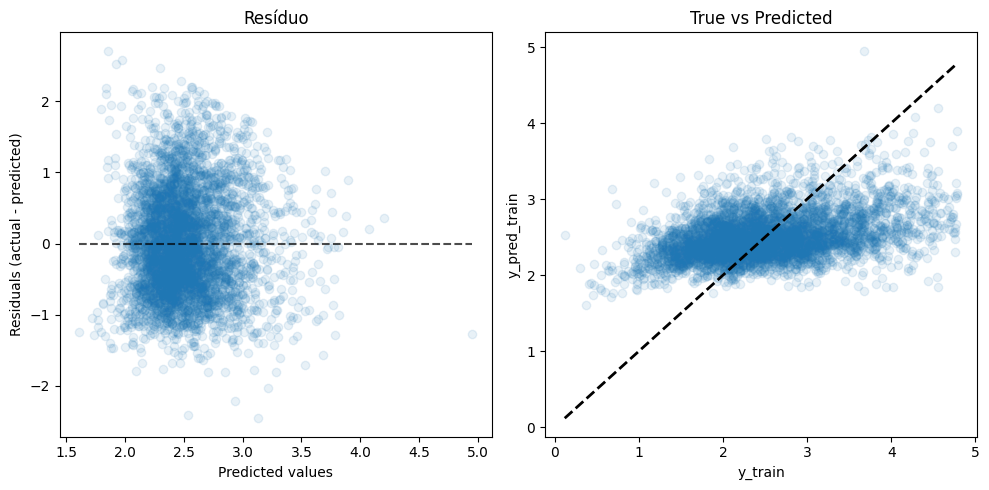

In [ ]:
# Gráfico dos resíduos para o conjunto de treinamento - preditores otimizados
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plotresid = PredictionErrorDisplay(y_true=y_train, y_pred=y_pred_train)
plotresid.plot(ax=ax[0], scatter_kwargs={'alpha': 0.1}) # Plot on the first axes
ax[0].set_title('Resíduo')

ax[1].scatter(y_train, y_pred_train, alpha=.1)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('y_pred_train')
ax[1].set_title('True vs Predicted')
# Add a 1:1 dashed line
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

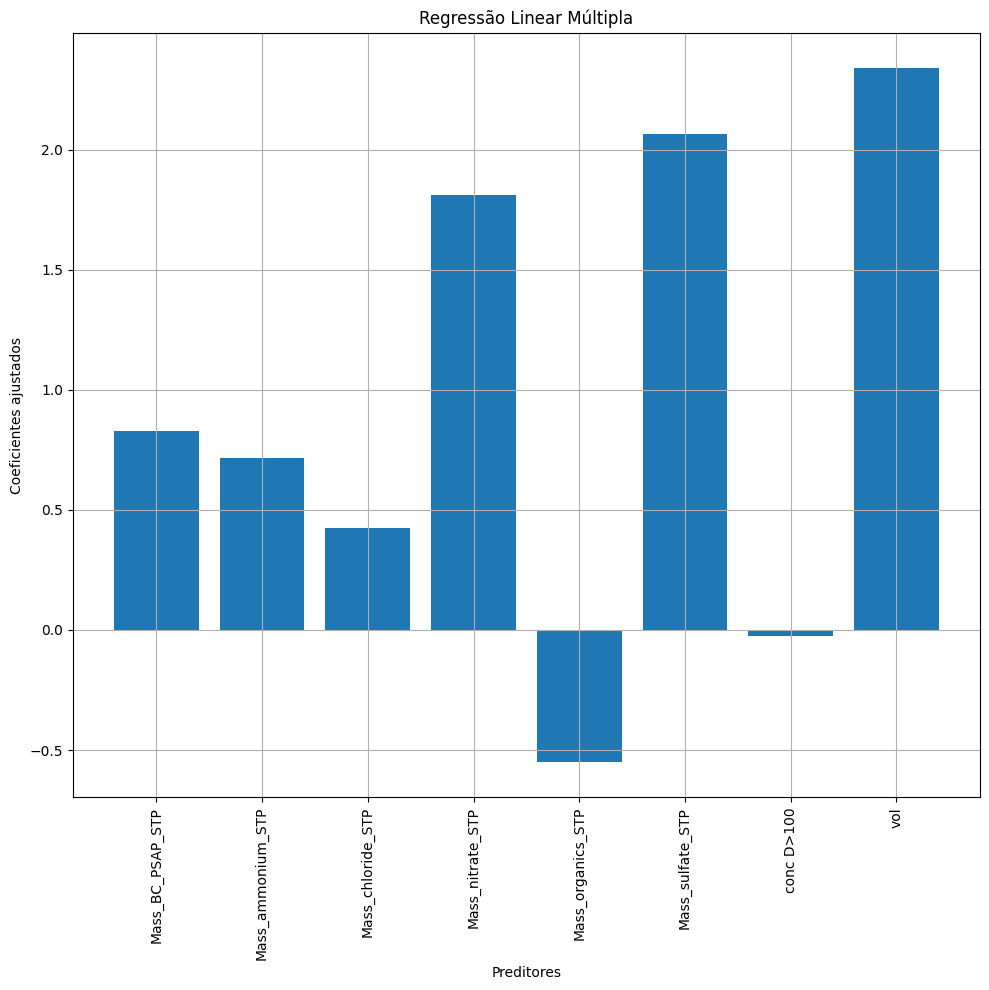

In [ ]:
# Gráfico dos coeficientes ajustados
nomes = X_train_s_reduced.columns # Use the columns from the reduced dataset
coef = regr.coef_
fig, ax = plt.subplots(figsize=(10, 10)) # Create figure and axes with desired size
ax.bar(np.arange(len(coef)), coef)
ax.set_xticks(np.arange(len(coef))) # Set the tick locations on the axes
ax.set_xticklabels(nomes, rotation=90) # Set the tick labels and rotate on the axes
ax.set_xlabel("Preditores")
ax.set_ylabel("Coeficientes ajustados")
ax.set_title("Regressão Linear Múltipla")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.grid()
plt.show()

Apesar da tentativa de melhorar o desempenho, aparentemente ele não mudou muito em relação à regressão anterior, mas pode inclusive ter piorado levemente. O R^2 (e R^2 ajustado) ainda não estão muito altos nem no treino, nem no teste, e as outras métricas (e sua interpretação, presença de outliers) não mudaram muito também. Os gráficos ainda podem ser interpretados de modo semelhante ao anterior, e ressalta-se que o modelo não parece descrever bem valores altos do alvo. A saída do statsmodels já não indica mais multicolinearidade, como esperado. Concluímos que talvez a Regresão Multilinear não seja a melhor regressão para essa predição; essa crença é sustentada pelas relações não lineares que pudemos observar no ScatterPlot dos preditores com o alvo, furando um dos pressupostos dessa regressão.

Por completude, em seguida implementamos uma regressão Lasso e uma Ridge com os preditores selecionados. É só uma ilustração de que não há ganhos, então os corficientes *alfa* não serão otimizados a princípio. Adotar-se-á como principal referência da regressão multilinear a feita acima, com os preditores selecionados e sem regularização, pois acredita-se que os benefício que Lasso ou Ridge trariam seria num contexto de mais preditores e com multicolinearidade, mas já  tratamos isso selecionando os preditores a partir da correlação.

# Exemplo: Regressão com Regularização - Lasso

In [ ]:
# Aplicando Lasso
from sklearn.linear_model import Lasso
a = 0.005
lassoReg = Lasso(alpha=a)
lassoReg.fit(X_train_s_reduced, y_train)
y_pred_train = lassoReg.predict(X_train_s_reduced) # predição para o conjunto de treino
y_pred_test = lassoReg.predict(X_test_s_reduced) # predição para o conjunto de teste

print('Intercepto:', lassoReg.intercept_)
nomes = X.columns
print(nomes)
print('Coeficientes:', lassoReg.coef_)
print('R^2 = ', lassoReg.score(X_train_s_reduced,y_train))


Intercepto: 1.9823676791365625
Index(['Mass_BC_PSAP_STP', 'Mass_ammonium_STP', 'Mass_chloride_STP',
       'Mass_nitrate_STP', 'Mass_organics_STP', 'Mass_sulfate_STP',
       'diam_geom_medio', 'conc D<50', 'conc D>100', 'area', 'vol'],
      dtype='object')
Coeficientes: [ 0.          0.          0.          1.08801053 -0.          1.0763015
  0.          1.61814119]
R^2 =  0.12338509212207271


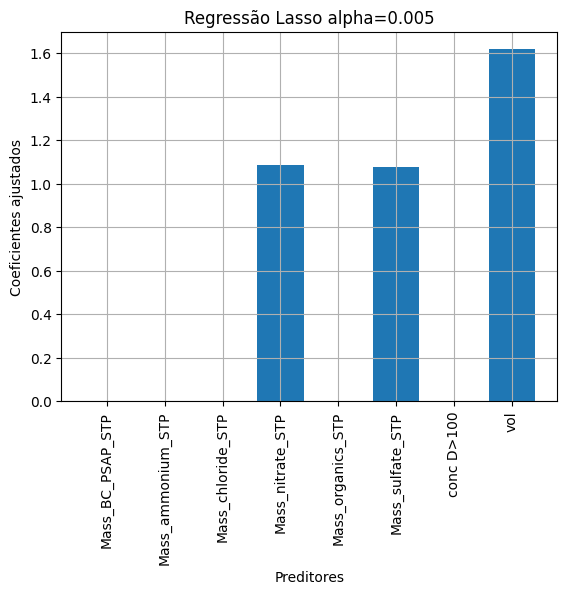

In [ ]:
# Gráfico dos coeficientes ajustados
nomes = X_train_s_reduced.columns
coef = lassoReg.coef_
ax = plt.bar(np.arange(len(coef)), coef)
plt.xticks(ticks=np.arange(len(coef)), labels=nomes, rotation=90)
plt.grid()
plt.xlabel("Preditores")
plt.ylabel("Coeficientes ajustados")
plt.title(f"Regressão Lasso alpha={a}")
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão Lasso')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))


Regressão Lasso
Desempenho no conjunto de treino
R^2 =  0.12338509212207271
MSE =  0.5545317632197443
MAE =  0.6027874460679403
Desempenho no conjunto de teste
R^2 =  0.11200087501363298
MSE =  0.5630277274889609
MAE =  0.6067536684178514


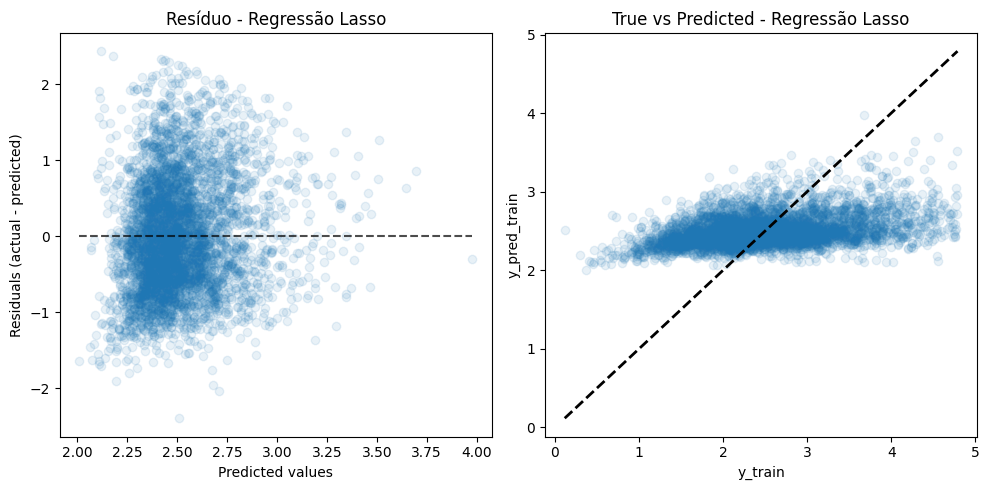

In [ ]:
# Gráfico dos resíduos para o conjunto de treinamento
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plotresid = PredictionErrorDisplay(y_true=y_train, y_pred=y_pred_train)
plotresid.plot(ax=ax[0], scatter_kwargs={'alpha': 0.1})
ax[0].set_title('Resíduo - Regressão Lasso')

ax[1].scatter(y_train, y_pred_train, alpha=.1)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('y_pred_train')
ax[1].set_title('True vs Predicted - Regressão Lasso')
# Add a 1:1 dashed line
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()


Pode-se ver que, de fato, não houve muitos ganhos, mas inclusive os problemas observados anteriormente podem ter sido agravados (pelo menos para o valor de alfa utilizado).

# Exemplo: Regressão com Regularização - Ridge

In [ ]:
# Aplicando Ridge
from sklearn.linear_model import Ridge
a = 0.75
ridgeReg = Ridge(alpha=a)
ridgeReg.fit(X_train_s_reduced,y_train)

y_pred_train = ridgeReg.predict(X_train_s_reduced) # predição para o conjunto de treino
y_pred_test = ridgeReg.predict(X_test_s_reduced) # predição para o conjunto de teste

print('Intercepto:', ridgeReg.intercept_)
nomes = X.columns
print(nomes)
print('Coeficientes:', ridgeReg.coef_)
print('R^2 = ', ridgeReg.score(X_train_s_reduced,y_train))


Intercepto: 1.1709705245681905
Index(['Mass_BC_PSAP_STP', 'Mass_ammonium_STP', 'Mass_chloride_STP',
       'Mass_nitrate_STP', 'Mass_organics_STP', 'Mass_sulfate_STP',
       'diam_geom_medio', 'conc D<50', 'conc D>100', 'area', 'vol'],
      dtype='object')
Coeficientes: [ 0.7852316   0.69008785  0.38270367  1.76275558 -0.52212708  1.99313271
 -0.01325669  2.28476728]
R^2 =  0.15006571686677783


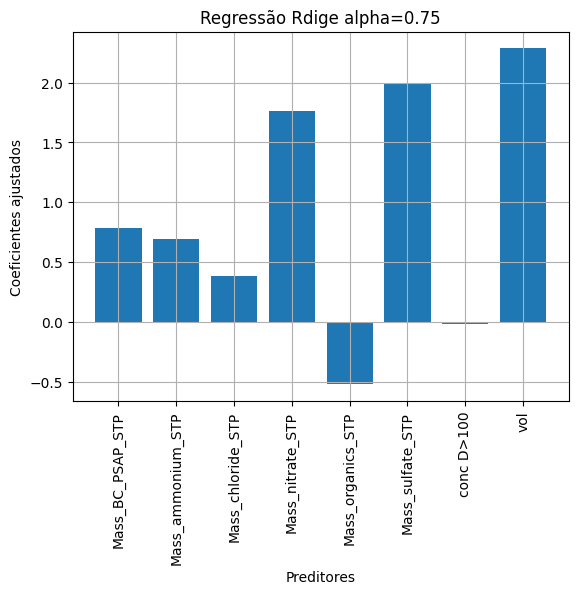

In [ ]:
# Gráfico dos coeficientes ajustados
nomes = X_train_s_reduced.columns
coef = ridgeReg.coef_
ax = plt.bar(np.arange(len(coef)), coef)
plt.xticks(ticks=np.arange(len(coef)), labels=nomes, rotation=90)
plt.grid()
plt.xlabel("Preditores")
plt.ylabel("Coeficientes ajustados")
plt.title(f"Regressão Rdige alpha={a}")
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão Ridge')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))


Regressão Ridge
Desempenho no conjunto de treino
R^2 =  0.15006571686677783
MSE =  0.5376540512957008
MAE =  0.593534610571152
Desempenho no conjunto de teste
R^2 =  0.13910910572602397
MSE =  0.5458400016176339
MAE =  0.5966276796093506


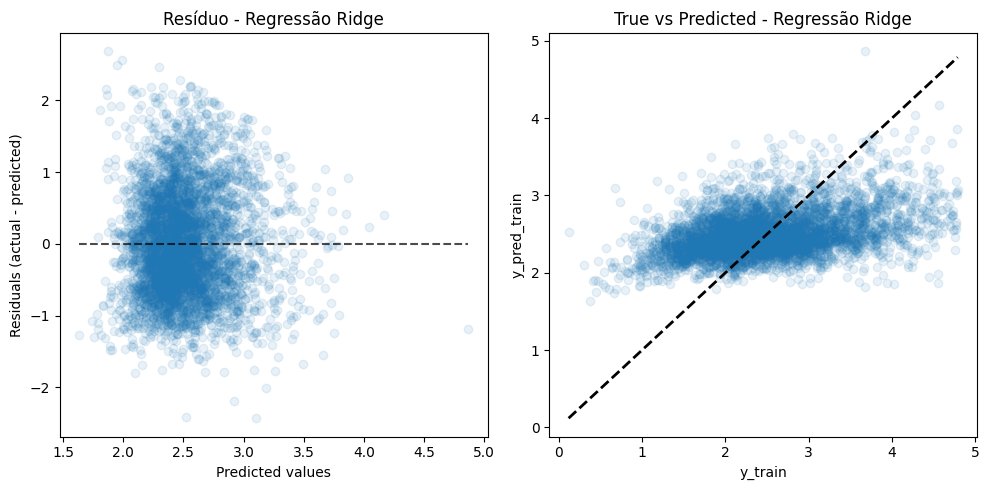

In [ ]:
# Gráfico dos resíduos para o conjunto de treinamento
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plotresid = PredictionErrorDisplay(y_true=y_train, y_pred=y_pred_train)
plotresid.plot(ax=ax[0], scatter_kwargs={'alpha': 0.1})
ax[0].set_title('Resíduo - Regressão Ridge')

ax[1].scatter(y_train, y_pred_train, alpha=.1)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('y_pred_train')
ax[1].set_title('True vs Predicted - Regressão Ridge')
# Add a 1:1 dashed line
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()


Novamente, não houve muitos ganhos, e os problemas observados anteriormente podem ter sido agravados (com o valor de alfa utilizado no exemplo).